# Exploratory Data Analysis, Part II

Content by Lisa Yan, Will Fithian, Joseph Gonzalez, Deborah Nolan, Sam Lau

Updated by Dominic Liu

A demo of data cleaning and exploratory data analysis using the CDC Tuberculosis data and the Mauna Loa CO2 data.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
# This option stops scientific notation for pandas
pd.set_option('display.float_format', '{:.2f}'.format)


## Structure: Multiple Files

Let's continue from where we left off last time. We loaded in the CDC Tuberculosis dataset, did some wrangling by inspecting it, and ended up with something like below.

In [3]:
rename_dict = {'2019': 'TB cases 2019',
               '2020': 'TB cases 2020',
               '2021': 'TB cases 2021',
               '2019.1': 'TB incidence 2019',
               '2020.1': 'TB incidence 2020',
               '2021.1': 'TB incidence 2021'}

tb_df = (
    pd.read_csv("data/cdc_tuberculosis.csv", header=1, thousands=',')
    .rename(columns=rename_dict)
)
tb_df = tb_df[1:] #Get rid of the first summary row
tb_df.head()

U.S. jurisdiction  TB cases 2019  TB cases 2020  TB cases 2021  \
1           Alabama             87             72             92   
2            Alaska             58             58             58   
3           Arizona            183            136            129   
4          Arkansas             64             59             69   
5        California           2111           1706           1750   

   TB incidence 2019  TB incidence 2020  TB incidence 2021  
1               1.77               1.43               1.83  
2               7.91               7.92               7.92  
3               2.51               1.89               1.77  
4               2.12               1.96               2.28  
5               5.35               4.32               4.46

### Gather Census Data

U.S. Census population estimates [source](https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html) (2019), [source](https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html) (2020-2021).

Running the below cells cleans the data. We encourage you to closely explore the CSV and study these lines after lecture...

There are a few new methods here:
* `df.convert_dtypes()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.convert_dtypes.html)) conveniently converts all float dtypes into ints and is out of scope for the class.
* `df.drop_na()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)) will be explained in more detail next time.

In [4]:
# 2010s census data
census_2010s_df = pd.read_csv("data/nst-est2019-01.csv", header=3, thousands=",")
census_2010s_df = (
    census_2010s_df
    .reset_index()
    .drop(columns=["index", "Census", "Estimates Base"])
    .rename(columns={"Unnamed: 0": "Geographic Area"})
    .convert_dtypes()                 # "smart" converting of columns, use at your own risk
    .dropna()                         # we'll introduce this very soon
)
census_2010s_df['Geographic Area'] = census_2010s_df['Geographic Area'].str.strip('.')

# with pd.option_context('display.min_rows', 30): # shows more rows
#     display(census_2010s_df)
    
census_2010s_df.head(10)

Geographic Area       2010       2011       2012       2013       2014  \
0   United States  309321666  311556874  313830990  315993715  318301008   
1       Northeast   55380134   55604223   55775216   55901806   56006011   
2         Midwest   66974416   67157800   67336743   67560379   67745167   
3           South  114866680  116006522  117241208  118364400  119624037   
4            West   72100436   72788329   73477823   74167130   74925793   
5         Alabama    4785437    4799069    4815588    4830081    4841799   
6          Alaska     713910     722128     730443     737068     736283   
7         Arizona    6407172    6472643    6554978    6632764    6730413   
8        Arkansas    2921964    2940667    2952164    2959400    2967392   
9      California   37319502   37638369   37948800   38260787   38596972   

        2015       2016       2017       2018       2019  
0  320635163  322941311  324985539  326687501  328239523  
1   56034684   56042330   56059240   56046620   55982803  
2   67860583   67987540   68126781   68236628   68329004  
3  120997341  122351760  123542189  124569433  125580448  
4   75742555   76559681   77257329   77834820   78347268  
5    4852347    4863525    4874486    4887681    4903185  
6     737498     741456     739700     735139     731545  
7    6829676    6941072    7044008    7158024    7278717  
8    2978048    2989918    3001345    3009733    3017804  
9   38918045   39167117   39358497   39461588   39512223

In [5]:
# census 2020s data
census_2020s_df = pd.read_csv("data/NST-EST2022-POP.csv", header=3, thousands=",")
census_2020s_df = (
    census_2020s_df
    .reset_index()
    .drop(columns=["index", "Unnamed: 1"])
    .rename(columns={"Unnamed: 0": "Geographic Area"})
    .convert_dtypes()    # "smart" converting of columns, use at your own risk
    .dropna()            # we'll introduce this next time
)
census_2020s_df['Geographic Area'] = census_2020s_df['Geographic Area'].str.strip('.')

census_2020s_df

Geographic Area       2020       2021       2022
0    United States  331511512  332031554  333287557
1        Northeast   57448898   57259257   57040406
2          Midwest   68961043   68836505   68787595
3            South  126450613  127346029  128716192
4             West   78650958   78589763   78743364
..             ...        ...        ...        ...
52      Washington    7724031    7740745    7785786
53   West Virginia    1791420    1785526    1775156
54       Wisconsin    5896271    5880101    5892539
55         Wyoming     577605     579483     581381
57     Puerto Rico    3281557    3262693    3221789

[57 rows x 4 columns]

### Join Data (Merge DataFrames)

Time to `merge`!

In [6]:
# merge TB dataframe with two US census dataframes
tb_census_df = (
    tb_df
    .merge(right=census_2010s_df,
           left_on="U.S. jurisdiction", right_on="Geographic Area")
    .merge(right=census_2020s_df,
           left_on="U.S. jurisdiction", right_on="Geographic Area")
)
tb_census_df

U.S. jurisdiction  TB cases 2019  TB cases 2020  TB cases 2021  \
0            Alabama             87             72             92   
1             Alaska             58             58             58   
2            Arizona            183            136            129   
3           Arkansas             64             59             69   
4         California           2111           1706           1750   
..               ...            ...            ...            ...   
46          Virginia            191            169            161   
47        Washington            221            163            199   
48     West Virginia              9             13              7   
49         Wisconsin             51             35             66   
50           Wyoming              1              0              3   

    TB incidence 2019  TB incidence 2020  TB incidence 2021 Geographic Area_x  \
0                1.77               1.43               1.83           Alabama   
1                7.91               7.92               7.92            Alaska   
2                2.51               1.89               1.77           Arizona   
3                2.12               1.96               2.28          Arkansas   
4                5.35               4.32               4.46        California   
..                ...                ...                ...               ...   
46               2.23               1.96               1.86          Virginia   
47               2.90               2.11               2.57        Washington   
48               0.50               0.73               0.39     West Virginia   
49               0.88               0.59               1.12         Wisconsin   
50               0.17               0.00               0.52           Wyoming   

        2010      2011      2012      2013      2014      2015      2016  \
0    4785437   4799069   4815588   4830081   4841799   4852347   4863525   
1     713910    722128    730443    737068    736283    737498    741456   
2    6407172   6472643   6554978   6632764   6730413   6829676   6941072   
3    2921964   2940667   2952164   2959400   2967392   2978048   2989918   
4   37319502  37638369  37948800  38260787  38596972  38918045  39167117   
..       ...       ...       ...       ...       ...       ...       ...   
46   8023699   8101155   8185080   8252427   8310993   8361808   8410106   
47   6742830   6826627   6897058   6963985   7054655   7163657   7294771   
48   1854239   1856301   1856872   1853914   1849489   1842050   1831023   
49   5690475   5705288   5719960   5736754   5751525   5760940   5772628   
50    564487    567299    576305    582122    582531    585613    584215   

        2017      2018      2019 Geographic Area_y      2020      2021  \
0    4874486   4887681   4903185           Alabama   5031362   5049846   
1     739700    735139    731545            Alaska    732923    734182   
2    7044008   7158024   7278717           Arizona   7179943   7264877   
3    3001345   3009733   3017804          Arkansas   3014195   3028122   
4   39358497  39461588  39512223        California  39501653  39142991   
..       ...       ...       ...               ...       ...       ...   
46   8463587   8501286   8535519          Virginia   8636471   8657365   
47   7423362   7523869   7614893        Washington   7724031   7740745   
48   1817004   1804291   1792147     West Virginia   1791420   1785526   
49   5790186   5807406   5822434         Wisconsin   5896271   5880101   
50    578931    577601    578759           Wyoming    577605    579483   

        2022  
0    5074296  
1     733583  
2    7359197  
3    3045637  
4   39029342  
..       ...  
46   8683619  
47   7785786  
48   1775156  
49   5892539  
50    581381  

[51 rows x 22 columns]

This is a little unwieldy. We could either drop the unneeded columns now, or just merge on smaller census DataFrames. Let's do the latter.

In [7]:
# try merging again, but cleaner this time
tb_census_df = (
    tb_df
    .merge(right=census_2010s_df[["Geographic Area", "2019"]],
           left_on="U.S. jurisdiction", right_on="Geographic Area")
    .drop(columns="Geographic Area")
    .merge(right=census_2020s_df[["Geographic Area", "2020", "2021"]],
           left_on="U.S. jurisdiction", right_on="Geographic Area")
    .drop(columns="Geographic Area")
)
tb_census_df

U.S. jurisdiction  TB cases 2019  TB cases 2020  TB cases 2021  \
0            Alabama             87             72             92   
1             Alaska             58             58             58   
2            Arizona            183            136            129   
3           Arkansas             64             59             69   
4         California           2111           1706           1750   
..               ...            ...            ...            ...   
46          Virginia            191            169            161   
47        Washington            221            163            199   
48     West Virginia              9             13              7   
49         Wisconsin             51             35             66   
50           Wyoming              1              0              3   

    TB incidence 2019  TB incidence 2020  TB incidence 2021      2019  \
0                1.77               1.43               1.83   4903185   
1                7.91               7.92               7.92    731545   
2                2.51               1.89               1.77   7278717   
3                2.12               1.96               2.28   3017804   
4                5.35               4.32               4.46  39512223   
..                ...                ...                ...       ...   
46               2.23               1.96               1.86   8535519   
47               2.90               2.11               2.57   7614893   
48               0.50               0.73               0.39   1792147   
49               0.88               0.59               1.12   5822434   
50               0.17               0.00               0.52    578759   

        2020      2021  
0    5031362   5049846  
1     732923    734182  
2    7179943   7264877  
3    3014195   3028122  
4   39501653  39142991  
..       ...       ...  
46   8636471   8657365  
47   7724031   7740745  
48   1791420   1785526  
49   5896271   5880101  
50    577605    579483  

[51 rows x 10 columns]

### Reproduce incidence

Let's recompute incidence to make sure we know where the original CDC numbers came from.

From the [CDC report](https://www.cdc.gov/mmwr/volumes/71/wr/mm7112a1.htm?s_cid=mm7112a1_w#T1_down): TB incidence is computed as “Cases per 100,000 persons using mid-year population estimates from the U.S. Census Bureau.”

If we define a group as 100,000 people, then we can compute the TB incidence for a given state population as

$$\text{TB incidence} = \frac{\text{# TB cases in population}}{\text{# groups in population}} = \frac{\text{# TB cases in population}}{\text{population}/100000} $$

$$= \frac{\text{# TB cases in population}}{\text{population}} \times 100000$$

Let's try this for 2019:

In [8]:
tb_census_df["recompute incidence 2019"] = tb_census_df["TB cases 2019"]/tb_census_df["2019"]*100000
tb_census_df

U.S. jurisdiction  TB cases 2019  TB cases 2020  TB cases 2021  \
0            Alabama             87             72             92   
1             Alaska             58             58             58   
2            Arizona            183            136            129   
3           Arkansas             64             59             69   
4         California           2111           1706           1750   
..               ...            ...            ...            ...   
46          Virginia            191            169            161   
47        Washington            221            163            199   
48     West Virginia              9             13              7   
49         Wisconsin             51             35             66   
50           Wyoming              1              0              3   

    TB incidence 2019  TB incidence 2020  TB incidence 2021      2019  \
0                1.77               1.43               1.83   4903185   
1                7.91               7.92               7.92    731545   
2                2.51               1.89               1.77   7278717   
3                2.12               1.96               2.28   3017804   
4                5.35               4.32               4.46  39512223   
..                ...                ...                ...       ...   
46               2.23               1.96               1.86   8535519   
47               2.90               2.11               2.57   7614893   
48               0.50               0.73               0.39   1792147   
49               0.88               0.59               1.12   5822434   
50               0.17               0.00               0.52    578759   

        2020      2021  recompute incidence 2019  
0    5031362   5049846                      1.77  
1     732923    734182                      7.93  
2    7179943   7264877                      2.51  
3    3014195   3028122                      2.12  
4   39501653  39142991                      5.34  
..       ...       ...                       ...  
46   8636471   8657365                      2.24  
47   7724031   7740745                      2.90  
48   1791420   1785526                      0.50  
49   5896271   5880101                      0.88  
50    577605    579483                      0.17  

[51 rows x 11 columns]

Awesome!!!

Let's use a for-loop and Python format strings to compute TB incidence for all years. Python f-strings are just used for the purposes of this demo, but they're handy to know when you explore data beyond this course ([Python documentation](https://docs.python.org/3/tutorial/inputoutput.html)).

In [9]:
# recompute incidence for all years
for year in [2019, 2020, 2021]:
    tb_census_df[f"recompute incidence {year}"] = tb_census_df[f"TB cases {year}"]/tb_census_df[f"{year}"]*100000
tb_census_df

U.S. jurisdiction  TB cases 2019  TB cases 2020  TB cases 2021  \
0            Alabama             87             72             92   
1             Alaska             58             58             58   
2            Arizona            183            136            129   
3           Arkansas             64             59             69   
4         California           2111           1706           1750   
..               ...            ...            ...            ...   
46          Virginia            191            169            161   
47        Washington            221            163            199   
48     West Virginia              9             13              7   
49         Wisconsin             51             35             66   
50           Wyoming              1              0              3   

    TB incidence 2019  TB incidence 2020  TB incidence 2021      2019  \
0                1.77               1.43               1.83   4903185   
1                7.91               7.92               7.92    731545   
2                2.51               1.89               1.77   7278717   
3                2.12               1.96               2.28   3017804   
4                5.35               4.32               4.46  39512223   
..                ...                ...                ...       ...   
46               2.23               1.96               1.86   8535519   
47               2.90               2.11               2.57   7614893   
48               0.50               0.73               0.39   1792147   
49               0.88               0.59               1.12   5822434   
50               0.17               0.00               0.52    578759   

        2020      2021  recompute incidence 2019  recompute incidence 2020  \
0    5031362   5049846                      1.77                      1.43   
1     732923    734182                      7.93                      7.91   
2    7179943   7264877                      2.51                      1.89   
3    3014195   3028122                      2.12                      1.96   
4   39501653  39142991                      5.34                      4.32   
..       ...       ...                       ...                       ...   
46   8636471   8657365                      2.24                      1.96   
47   7724031   7740745                      2.90                      2.11   
48   1791420   1785526                      0.50                      0.73   
49   5896271   5880101                      0.88                      0.59   
50    577605    579483                      0.17                      0.00   

    recompute incidence 2021  
0                       1.82  
1                       7.90  
2                       1.78  
3                       2.28  
4                       4.47  
..                       ...  
46                      1.86  
47                      2.57  
48                      0.39  
49                      1.12  
50                      0.52  

[51 rows x 13 columns]

These numbers look pretty close!!! There are a few errors in the hundredths place, particularly in 2021. It may be useful to further explore reasons behind this discrepancy. We'll leave it to you!

I'll also leave the part with reproducing the "9.4%" increase to you! Or, you can also check the bonus section in Lecture 4's demo notebook to see how we did it.


<br/><br/><br/>

---

## Structure: Different File Formats

There are many file types for storing structured data: CSV, TSV, JSON, XML, ASCII, SAS...
* Documentation will be your best friend to understand how to process many of these file types.
* In lecture, we will cover TSV and JSON since pandas supports them out-of-box.

### TSV

**TSV** (Tab-Separated Values) files are very similar to CSVs, but now items are delimited by tabs.

Let's check out `cdc_tuberculosis.tsv`, which is the same data but now in a TSV.

1. To the Jupyter view!

1. To the Python view!

    Quick Python reminders:
    * Python's `print()` prints each string (including the newline), and an additional newline on top of that.
    * We use the `repr()` function to return the raw string with all special characters:

In [10]:
with open("data/cdc_tuberculosis.tsv", "r") as f:
    i = 0
    for row in f:
        print(repr(row)) # print raw strings
        i += 1
        if i > 3:
            break

'\tNo. of TB cases\t\t\tTB incidence\t\t\n'
'U.S. jurisdiction\t2019\t2020\t2021\t2019\t2020\t2021\n'
'Total\t"8,900"\t"7,173"\t"7,860"\t2.71\t2.16\t2.37\n'
'Alabama\t87\t72\t92\t1.77\t1.43\t1.83\n'


The `pd.read_csv` function also reads in TSVs if we specify the **delimiter** with parameter `sep='\t'` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)).

In [11]:
tuberculosis_df_tsv = pd.read_csv("data/cdc_tuberculosis.tsv", sep='\t')
tuberculosis_df_tsv.head()

Unnamed: 0 No. of TB cases Unnamed: 2 Unnamed: 3  TB incidence  \
0  U.S. jurisdiction            2019       2020       2021       2019.00   
1              Total           8,900      7,173      7,860          2.71   
2            Alabama              87         72         92          1.77   
3             Alaska              58         58         58          7.91   
4            Arizona             183        136        129          2.51   

   Unnamed: 5  Unnamed: 6  
0     2020.00     2021.00  
1        2.16        2.37  
2        1.43        1.83  
3        7.92        7.92  
4        1.89        1.77

*Side note*: there was a question last time on how pandas differentiates a comma delimiter vs. a comma within the field itself, e.g., `8,900`. Check out the documentation for the `quotechar` parameter.

### JSON
The City of Berkeley Open Data [website](https://data.cityofberkeley.info/Health/COVID-19-Confirmed-Cases/xn6j-b766) has a dataset with COVID-19 Confirmed Cases among Berkeley residents by date.

Let's first check out this website.

Next, let's download this file, saving it as a JSON (note the source URL file type).

In the interest of **reproducible data science** we will download the data programatically.  We have defined some helper functions in the [ds100_utils.py](ds100_utils.py) file.  I can then reuse these helper functions in many different notebooks.

In [12]:
# just run this cell
from ds100_utils import fetch_and_cache

Occasionally, you will want to modify code that you have imported from a local Python library.  To reimport those modifications you can either use the python importlib library:

```python
from importlib import reload
reload(utils)
```

or use iPython magic which will intelligently import code when files change:

```python
%load_ext autoreload
%autoreload 2
```

In [13]:
covid_file = fetch_and_cache(
    "https://data.cityofberkeley.info/api/views/xn6j-b766/rows.json?accessType=DOWNLOAD",
    "confirmed-cases.json",
    force=False)
covid_file          # a file path wrapper object

Using cached version that was downloaded (UTC): Tue Jun 27 07:40:10 2023


PosixPath('data/confirmed-cases.json')

#### File size

Often, I like to start my analysis by getting a rough estimate of the size of the data.  This will help inform the tools I use and how I view the data.  If it is relatively small I might use a text editor or a spreadsheet to look at the data.  If it is larger, I might jump to more programmatic exploration or even used distributed computing tools.

However here we will use Python tools to probe the file.

Since these seem to be text files I might also want to investigate the number of lines, which often corresponds to the number of records.

In [14]:
import os

print(covid_file, "is", os.path.getsize(covid_file) / 1e6, "MB")

with open(covid_file, "r") as f:
    print(covid_file, "is", sum(1 for l in f), "lines.")

data/confirmed-cases.json is 0.205583 MB
data/confirmed-cases.json is 1707 lines.


#### File contents

Because we have a text file in a visual IDE like Jupyter/DataHub, I'm going to visually explore the data via the built-in file explorer.

1. To the Jupyter view!

2. To the Python view...?

In [15]:
with open(covid_file, "r") as f:
    i = 0
    for row in f:
        print(repr(row)) # print raw strings
        i += 1
        if i > 5:
            break

'{\n'
'  "meta" : {\n'
'    "view" : {\n'
'      "id" : "xn6j-b766",\n'
'      "name" : "COVID-19 Confirmed Cases",\n'
'      "assetType" : "dataset",\n'


1. Back to the Python view.

    In order to load the JSON file into pandas, Let's first do some **EDA** with the Python `json` package to understand the particular structure of this JSON file so that we can decide what (if anything) to load into Pandas. 

### EDA: Digging into JSON

Python has relatively good support for JSON data since it closely matches the internal python object model.  In the following cell we import the entire JSON datafile into a python dictionary using the `json` package.

In [16]:
import json

with open(covid_file, "rb") as f:
    covid_json = json.load(f)

The `covid_json` variable is now a dictionary encoding the data in the file:

In [17]:
type(covid_json)

dict

#### Examine what keys are in the top level json object

We can list the keys to determine what data is stored in the object.

In [18]:
covid_json.keys()

dict_keys(['meta', 'data'])

**Observation**: The JSON dictionary contains a `meta` key which likely refers to meta data (data about the data).  Meta data often maintained with the data and can be a good source of additional information.

<br/>

We can investigate the meta data further by examining the keys associated with the metadata.

In [19]:
covid_json['meta'].keys()

dict_keys(['view'])

The `meta` key contains another dictionary called `view`.  This likely refers to meta-data about a particular "view" of some underlying database.  We will learn more about views when we study SQL later in the class.    

In [20]:
covid_json['meta']['view'].keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'clientContext', 'columns', 'grants', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

Notice that this a nested/recursive data structure.  As we dig deeper we reveal more and more keys and the corresponding data:

```
meta
|-> data
    | ... (haven't explored yet)
|-> view
    | -> id
    | -> name
    | -> attribution 
    ...
    | -> description
    ...
    | -> columns
    ...
```

There is a key called description in the view sub dictionary.  This likely contains a description of the data:

In [21]:
print(covid_json['meta']['view']['description'])

Counts of confirmed COVID-19 cases among Berkeley residents by date. As of 6/21/22, this dataset will be updated weekly instead of daily. As of 11/14/22, this dataset only includes PCR cases.



#### Examining the Data Field for Records

We can look at a few entries in the `data` field. This is what we'll load into Pandas.


In [22]:
for i in range(3):
    print(f"{i:03} | {covid_json['data'][i]}")

000 | ['row-yeww~gvnm.g68w', '00000000-0000-0000-386C-533081785A3A', 0, 1687370769, None, 1687370769, None, '{ }', '2019-12-01T00:00:00', '0', '0']
001 | ['row-fsx2.86py_bzpc', '00000000-0000-0000-FF2C-E5BC42CD0EE9', 0, 1687370769, None, 1687370769, None, '{ }', '2019-12-02T00:00:00', '0', '0']
002 | ['row-ggah~5w7b~ce8n', '00000000-0000-0000-6EFB-E68400EBBD1E', 0, 1687370769, None, 1687370769, None, '{ }', '2019-12-03T00:00:00', '0', '0']


Observations:
* These look like equal-length records, so maybe `data` is a table!
* But what do each of values in the record mean? Where can we find column headers?

Back to the metadata.

#### Columns Metadata

Another potentially useful key in the metadata dictionary is the `columns`.  This returns a list:

In [23]:
type(covid_json['meta']['view']['columns'])

list

Let's go back to the file explorer.

Based on the contents of this key, what are reasonable names for each column in the `data` table?

#### Summary of exploring the JSON file

1. The above **metadata** tells us a lot about the columns in the data including column names, potential data anomalies, and a basic statistic. 
1. Because of its non-tabular structure, JSON makes it easier (than CSV) to create **self-documenting data**, meaning that information about the data is stored in the same file as the data.
1. Self documenting data can be helpful since it maintains its own description and these descriptions are more likely to be updated as data changes. 

### JSON with pandas

After our above EDA, let's finally go about loading the data (not the metadata) into a pandas dataframe.

In the following block of code we:
1. Translate the JSON records into a dataframe:

    * fields: `covid_json['meta']['view']['columns']`
    * records: `covid_json['data']`
    
1. Remove columns that have no metadata description.  This would be a bad idea in general but here we remove these columns since the above analysis suggests that they are unlikely to contain useful information.
1. Examine the `tail` of the table.

In [24]:
# Load the data from JSON and assign column titles
covid = pd.DataFrame(
    covid_json['data'],
    columns=[c['name'] for c in covid_json['meta']['view']['columns']])

covid.tail()

sid                                    id  position  \
1292  row-zg3v~6bpx~tp8j  00000000-0000-0000-7710-AECCCEB67A5A         0   
1293  row-wean-73e3.fixn  00000000-0000-0000-27C0-D21340C3F93F         0   
1294  row-cvez.6nyd.3f6y  00000000-0000-0000-C1AE-C76310119F30         0   
1295  row-hzcg-24ra_7ipd  00000000-0000-0000-D048-D04E71C55E3A         0   
1296  row-8tdn_tuw8_hujn  00000000-0000-0000-3181-E8EECFBF2249         0   

      created_at created_meta  updated_at updated_meta meta  \
1292  1687370769         None  1687370769         None  { }   
1293  1687370769         None  1687370769         None  { }   
1294  1687370769         None  1687370769         None  { }   
1295  1687370769         None  1687370769         None  { }   
1296  1687370769         None  1687370769         None  { }   

                     Date New Cases Cumulative Cases  
1292  2023-06-15T00:00:00         2            23384  
1293  2023-06-16T00:00:00         4            23388  
1294  2023-06-17T00:00:00         2            23390  
1295  2023-06-18T00:00:00         0            23390  
1296  2023-06-19T00:00:00         0            23390

<br/>

---


## Temporality

Let's briefly look at how we can use pandas `dt` accessors to work with dates/times in a dataset.

We will use the dataset from Lab 3: the Berkeley PD Calls for Service dataset.

In [25]:
calls = pd.read_csv("data/Berkeley_PD_-_Calls_for_Service.csv")
calls.head()

CASENO                   OFFENSE                 EVENTDT EVENTTM  \
0  21014296  THEFT MISD. (UNDER $950)  04/01/2021 12:00:00 AM   10:58   
1  21014391  THEFT MISD. (UNDER $950)  04/01/2021 12:00:00 AM   10:38   
2  21090494  THEFT MISD. (UNDER $950)  04/19/2021 12:00:00 AM   12:15   
3  21090204  THEFT FELONY (OVER $950)  02/13/2021 12:00:00 AM   17:00   
4  21090179             BURGLARY AUTO  02/08/2021 12:00:00 AM    6:20   

             CVLEGEND  CVDOW                InDbDate  \
0             LARCENY      4  06/15/2021 12:00:00 AM   
1             LARCENY      4  06/15/2021 12:00:00 AM   
2             LARCENY      1  06/15/2021 12:00:00 AM   
3             LARCENY      6  06/15/2021 12:00:00 AM   
4  BURGLARY - VEHICLE      1  06/15/2021 12:00:00 AM   

                                      Block_Location                BLKADDR  \
0             Berkeley, CA\n(37.869058, -122.270455)                    NaN   
1             Berkeley, CA\n(37.869058, -122.270455)                    NaN   
2  2100 BLOCK HASTE ST\nBerkeley, CA\n(37.864908,...    2100 BLOCK HASTE ST   
3  2600 BLOCK WARRING ST\nBerkeley, CA\n(37.86393...  2600 BLOCK WARRING ST   
4  2700 BLOCK GARBER ST\nBerkeley, CA\n(37.86066,...   2700 BLOCK GARBER ST   

       City State  
0  Berkeley    CA  
1  Berkeley    CA  
2  Berkeley    CA  
3  Berkeley    CA  
4  Berkeley    CA

Looks like there are three columns with dates/times: `EVENTDT`, `EVENTTM`, and `InDbDate`. 

Most likely, `EVENTDT` stands for the date when the event took place, `EVENTTM` stands for the time of day the event took place (in 24-hr format), and `InDbDate` is the date this call is recorded onto the database.

If we check the data type of these columns, we will see they are stored as strings. We can convert them to `datetime` objects using pandas `to_datetime` function.

In [26]:
calls["EVENTDT"] = pd.to_datetime(calls["EVENTDT"])
calls.head()

CASENO                   OFFENSE    EVENTDT EVENTTM            CVLEGEND  \
0  21014296  THEFT MISD. (UNDER $950) 2021-04-01   10:58             LARCENY   
1  21014391  THEFT MISD. (UNDER $950) 2021-04-01   10:38             LARCENY   
2  21090494  THEFT MISD. (UNDER $950) 2021-04-19   12:15             LARCENY   
3  21090204  THEFT FELONY (OVER $950) 2021-02-13   17:00             LARCENY   
4  21090179             BURGLARY AUTO 2021-02-08    6:20  BURGLARY - VEHICLE   

   CVDOW                InDbDate  \
0      4  06/15/2021 12:00:00 AM   
1      4  06/15/2021 12:00:00 AM   
2      1  06/15/2021 12:00:00 AM   
3      6  06/15/2021 12:00:00 AM   
4      1  06/15/2021 12:00:00 AM   

                                      Block_Location                BLKADDR  \
0             Berkeley, CA\n(37.869058, -122.270455)                    NaN   
1             Berkeley, CA\n(37.869058, -122.270455)                    NaN   
2  2100 BLOCK HASTE ST\nBerkeley, CA\n(37.864908,...    2100 BLOCK HASTE ST   
3  2600 BLOCK WARRING ST\nBerkeley, CA\n(37.86393...  2600 BLOCK WARRING ST   
4  2700 BLOCK GARBER ST\nBerkeley, CA\n(37.86066,...   2700 BLOCK GARBER ST   

       City State  
0  Berkeley    CA  
1  Berkeley    CA  
2  Berkeley    CA  
3  Berkeley    CA  
4  Berkeley    CA

Now we can use the `dt` accessor on this column.

We can get the month:

In [27]:
calls["EVENTDT"].dt.month

0        4
1        4
2        4
3        2
4        2
        ..
2627    12
2628     2
2629     3
2630     4
2631     2
Name: EVENTDT, Length: 2632, dtype: int64

Which day of the week the date is on:

In [28]:
calls["EVENTDT"].dt.dayofweek

0       3
1       3
2       0
3       5
4       0
       ..
2627    0
2628    2
2629    2
2630    5
2631    4
Name: EVENTDT, Length: 2632, dtype: int64

Check the mimimum values to see if there are any suspicious-looking, 70s dates:

In [29]:
calls.sort_values("EVENTDT").head()

CASENO                   OFFENSE    EVENTDT EVENTTM  \
2513  20057398       BURGLARY COMMERCIAL 2020-12-17   16:05   
624   20057207     ASSAULT/BATTERY MISD. 2020-12-17   16:50   
154   20092214           THEFT FROM AUTO 2020-12-17   18:30   
659   20057324  THEFT MISD. (UNDER $950) 2020-12-17   15:44   
993   20057573      BURGLARY RESIDENTIAL 2020-12-17   22:15   

                    CVLEGEND  CVDOW                InDbDate  \
2513   BURGLARY - COMMERCIAL      4  06/15/2021 12:00:00 AM   
624                  ASSAULT      4  06/15/2021 12:00:00 AM   
154   LARCENY - FROM VEHICLE      4  06/15/2021 12:00:00 AM   
659                  LARCENY      4  06/15/2021 12:00:00 AM   
993   BURGLARY - RESIDENTIAL      4  06/15/2021 12:00:00 AM   

                                         Block_Location  \
2513  600 BLOCK GILMAN ST\nBerkeley, CA\n(37.878405,...   
624   2100 BLOCK SHATTUCK AVE\nBerkeley, CA\n(37.871...   
154   800 BLOCK SHATTUCK AVE\nBerkeley, CA\n(37.8918...   
659   1800 BLOCK 4TH ST\nBerkeley, CA\n(37.869888, -...   
993   1700 BLOCK STUART ST\nBerkeley, CA\n(37.857495...   

                      BLKADDR      City State  
2513      600 BLOCK GILMAN ST  Berkeley    CA  
624   2100 BLOCK SHATTUCK AVE  Berkeley    CA  
154    800 BLOCK SHATTUCK AVE  Berkeley    CA  
659         1800 BLOCK 4TH ST  Berkeley    CA  
993      1700 BLOCK STUART ST  Berkeley    CA

Doesn't look like it! We are good!


We can also do many things with the `dt` accessor like switching time zones and converting time back to UNIX/POSIX time. Check out the documentation on [`.dt` accessor](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dt-accessors) and [time series/date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html#).

---
<br/><br/>

## Data Faithfulness: Mauna Loa CO2 data

CO2 concentrations have been monitored at Mauna Loa Observatory since 1958 ([website link](https://gml.noaa.gov/ccgg/trends/data.html)).




In [30]:
co2_file = "data/co2_mm_mlo.txt"

Let's do some **EDA**!!

### How do we read the file into Pandas?
Let's instead check out this file with JupyterLab.

* Note it's a `.txt` file.
* Do we trust this file extension?
* What structure is it?


---
<br/><br/><br/><br/><br/>

Looking at the first few lines of the data, we spot some relevant characteristics:

- The values are separated by white space, possibly tabs.
- The data line up down the rows. For example, the month appears in 7th to 8th position of each line.
- The 71st and 72nd lines in the file contain column headings split over two lines.

We can use `read_csv` to read the data into a Pandas data frame, and we provide several arguments to specify that the separators are white space, there is no header (**we will set our own column names**), and to skip the first 72 rows of the file.

In [31]:
co2 = pd.read_csv(
    co2_file, header = None, skiprows = 72,
    sep = r'\s+'       #delimiter for continuous whitespace (stay tuned for regex next lecture))
)
co2.head()

0  1       2      3      4      5  6
0  1958  3 1958.21 315.71 315.71 314.62 -1
1  1958  4 1958.29 317.45 317.45 315.29 -1
2  1958  5 1958.38 317.50 317.50 314.71 -1
3  1958  6 1958.46 -99.99 317.10 314.85 -1
4  1958  7 1958.54 315.86 315.86 314.98 -1

Congratulations! You've wrangled the data!

<br/>

...But our columns aren't named.
**We need to do more EDA.**

### Exploring Variable Feature Types

The NOAA [webpage](https://gml.noaa.gov/ccgg/trends/) might have some useful tidbits (in this case it doesn't).
Let's go back to the raw data file to identify each feature.


We'll rerun `pd.read_csv`, but this time with some **custom column names.**

In [32]:
co2 = pd.read_csv(
    co2_file, header = None, skiprows = 72,
    sep = '\s+', #regex for continuous whitespace (next lecture)
    names = ['Yr', 'Mo', 'DecDate', 'Avg', 'Int', 'Trend', 'Days']
)
co2.head()

Yr  Mo  DecDate    Avg    Int  Trend  Days
0  1958   3  1958.21 315.71 315.71 314.62    -1
1  1958   4  1958.29 317.45 317.45 315.29    -1
2  1958   5  1958.38 317.50 317.50 314.71    -1
3  1958   6  1958.46 -99.99 317.10 314.85    -1
4  1958   7  1958.54 315.86 315.86 314.98    -1

### Visualizing CO2 

Scientific studies tend to have very clean data, right...? Let's jump right in and make a time series plot of CO2 monthly averages.

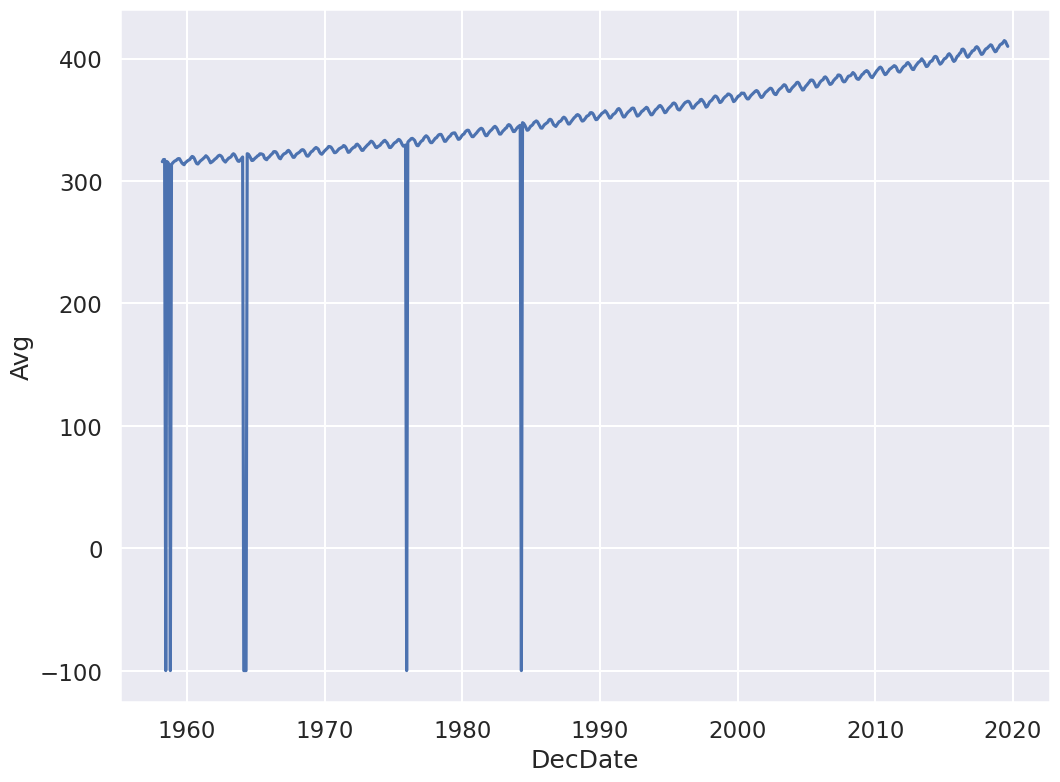

In [33]:
sns.lineplot(x='DecDate', y='Avg', data=co2);

The code above uses the `seaborn` plotting library (abbreviated `sns`). We will cover this on Thursday, but now you don't need to worry about how it works!


Yikes! Plotting the data uncovered a problem. It looks like we have some **missing values**. What happened here? 

In [34]:
co2.head()

Yr  Mo  DecDate    Avg    Int  Trend  Days
0  1958   3  1958.21 315.71 315.71 314.62    -1
1  1958   4  1958.29 317.45 317.45 315.29    -1
2  1958   5  1958.38 317.50 317.50 314.71    -1
3  1958   6  1958.46 -99.99 317.10 314.85    -1
4  1958   7  1958.54 315.86 315.86 314.98    -1

In [35]:
co2.tail()

Yr  Mo  DecDate    Avg    Int  Trend  Days
733  2019   4  2019.29 413.32 413.32 410.49    26
734  2019   5  2019.38 414.66 414.66 411.20    28
735  2019   6  2019.46 413.92 413.92 411.58    27
736  2019   7  2019.54 411.77 411.77 411.43    23
737  2019   8  2019.62 409.95 409.95 411.84    29

Some data have unusual values like -1 and -99.99.

Let's check the description at the top of the file again.
1. -1 signifies a missing value for the number of days `Days` the equipment was in operation that month.
1. -99.99 denotes a missing monthly average `Avg`

How can we fix this? First, let's explore other aspects of our data. Understanding our data will help us decide what to do with the missing values.

<br/>


### Sanity Checks: Reasoning about the data
First, we consider the shape of the data. How many rows should we have?
* If chronological order, we should have one record per month.
* Data from March 1958 to August 2019.
* We should have $ 12 \times (2019-1957) - 2 - 4 = 738 $ records.

In [36]:
co2.shape

(738, 7)

Nice!! The number of rows (i.e. records) match our expectations.

<br/><br/>

---

Let's now check the quality of each feature.

### Understanding Missing Value 1: `Days`
`Days` is a time field, so let's analyze other time fields to see if there is an explanation for missing values of days of operation.

Let's start with **months** `Mo`.

Are we missing any records? The number of months should have 62 or 61 instances (March 1957-August 2019).

In [37]:
co2["Mo"].value_counts().sort_index()

1     61
2     61
3     62
4     62
5     62
6     62
7     62
8     62
9     61
10    61
11    61
12    61
Name: Mo, dtype: int64

As expected Jan, Feb, Sep, Oct, Nov, and Dec have 61 occurrences and the rest 62.

<br/><br/>

Next let's explore **days** `Days` itself, which is the number of days that the measurement equipment worked.

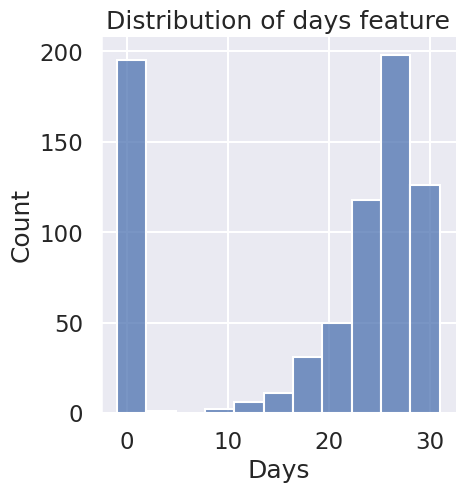

In [38]:
sns.displot(co2['Days']);
plt.title("Distribution of days feature")
plt.show() # suppresses unneeded plotting output

In terms of data quality, a handful of months have averages based on measurements taken on fewer than half the days. In addition, there are nearly 200 missing values--**that's about 27% of the data**!

<br/><br/>

Finally, let's check the last time feature, **year** `Yr`.

Let's check to see if there is any connection between missingness and the year of the recording.

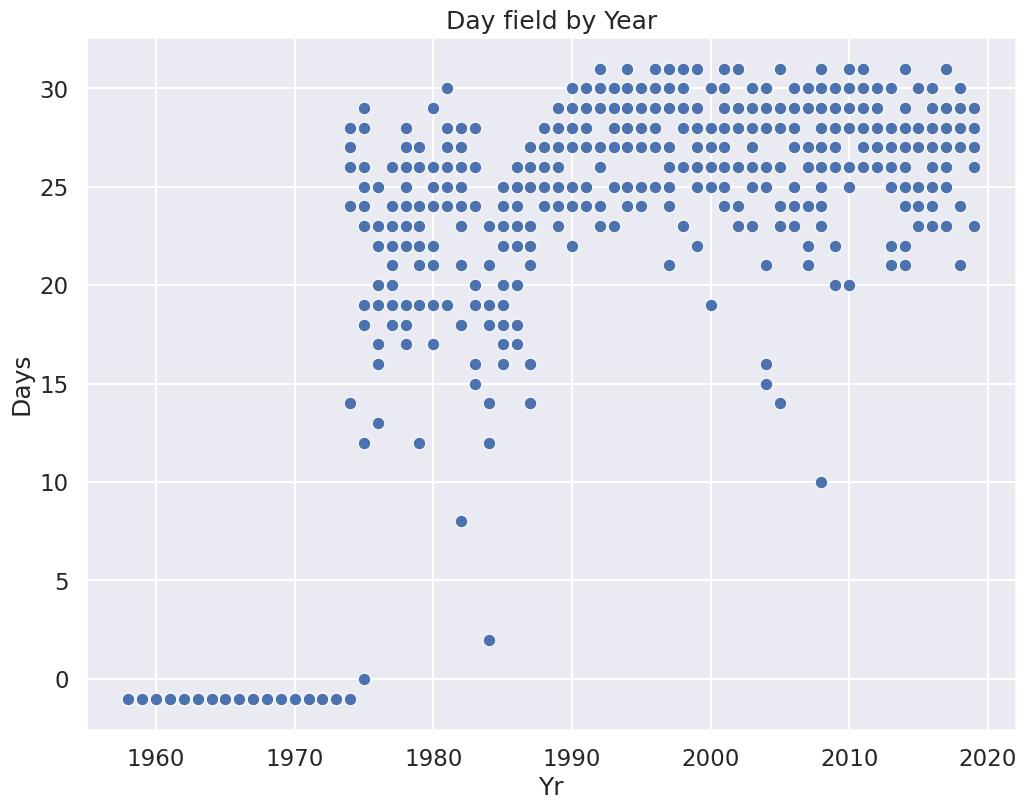

In [39]:
sns.scatterplot(x="Yr", y="Days", data=co2);
plt.title("Day field by Year"); # the ; suppresses output

**Observations**:

* All of the missing data are in the early years of operation.
* It appears there may have been problems with equipment in the mid to late 80s.

**Potential Next Steps**:
* Confirm these explanations through documentation about the historical readings.
* Maybe drop earliest recordings? However, we would want to delay such action until after we have examined the time trends and assess whether there are any potential problems.

---
<br/><br/>

### Understanding Missing Value 2: `Avg`
Next, let's return to the -99.99 values in `Avg` to analyze the overall quality of the CO2 measurements.

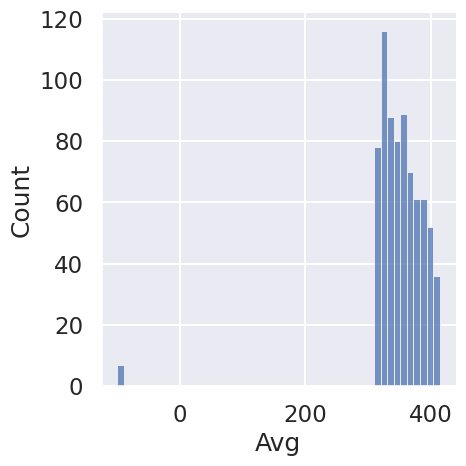

In [40]:
# Histograms of average CO2 measurements
sns.displot(co2['Avg']);

The non-missing values are in the 300-400 range (a regular range of CO2 levels).

We also see that there are only a few missing `Avg` values (**<1% of values**). Let's examine all of them:

In [41]:
co2[co2["Avg"] < 0]

Yr  Mo  DecDate    Avg    Int  Trend  Days
3    1958   6  1958.46 -99.99 317.10 314.85    -1
7    1958  10  1958.79 -99.99 312.66 315.61    -1
71   1964   2  1964.12 -99.99 320.07 319.61    -1
72   1964   3  1964.21 -99.99 320.73 319.55    -1
73   1964   4  1964.29 -99.99 321.77 319.48    -1
213  1975  12  1975.96 -99.99 330.59 331.60     0
313  1984   4  1984.29 -99.99 346.84 344.27     2

There doesn't seem to be a pattern to these values, other than that most records also were missing `Days` data.

### Drop, `NaN`, or Impute Missing `Avg` Data?

How should we address the invalid `Avg` data?

A. Drop records

B. Set to NaN

C. Impute using some strategy

Remember we want to fix the following plot:

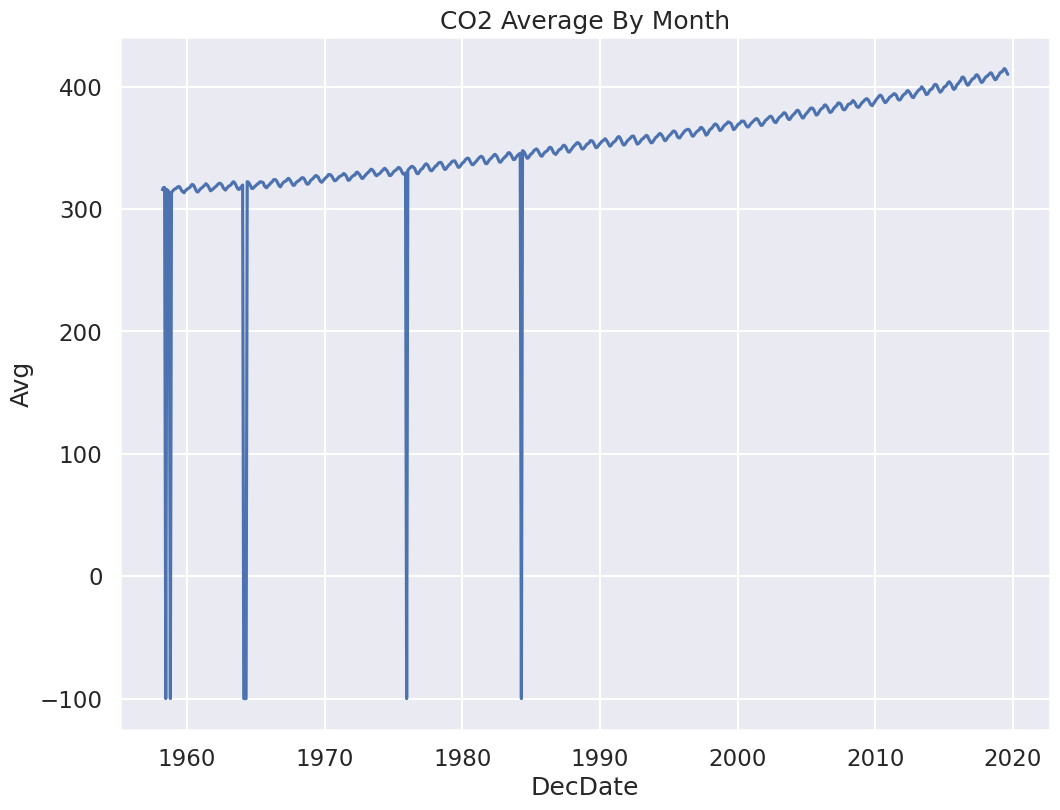

In [42]:
sns.lineplot(x='DecDate', y='Avg', data=co2)
plt.title("CO2 Average By Month");

Since we are plotting `Avg` vs `DecDate`, we should just focus on dealing with missing values for `Avg`.

Let's consider a few options:
1. Drop those records
1. Replace -99.99 with NaN
1. Substitute it with a likely value for the average CO2?

What do you think are the pros and cons of each possible action?

---
<br/><br/>
Let's examine each of these three options.

In [43]:
# 1. Drop missing values
co2_drop = co2[co2['Avg'] > 0]

# 2. Replace NaN with -99.99
co2_NA = co2.replace(-99.99, np.NaN)

We'll also use a third version of the data.
First, we note that the dataset already comes with a **substitute value** for the -99.99.

From the file description:

>  The `interpolated` column includes average values from the preceding column (`average`)
and **interpolated values** where data are missing.  Interpolated values are
computed in two steps...

The `Int` feature has values that exactly match those in `Avg`, except when `Avg` is -99.99, and then a **reasonable** estimate is used instead.
So, the third version of our data will use the `Int` feature instead of `Avg`.

In [44]:
# 3. Use interpolated column which estimates missing Avg values
co2_impute = co2.copy()
co2_impute['Avg'] = co2['Int']

<br/>

---

What's a **reasonable** estimate?

To answer this question, let's zoom in on a short time period, say the measurements in 1958 (where we know we have two missing values).


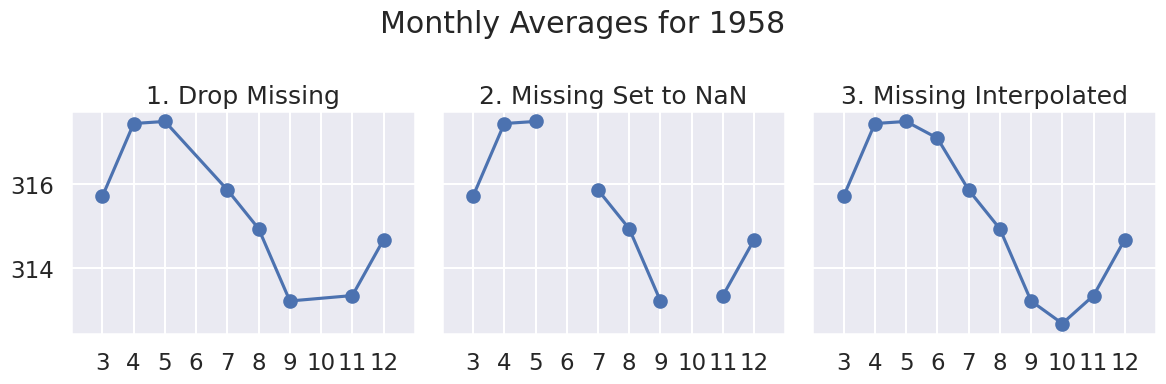

In [45]:
# results of plotting data in 1958

def line_and_points(data, ax, title):
    # assumes single year, hence Mo
    ax.plot('Mo', 'Avg', data=data)
    ax.scatter('Mo', 'Avg', data=data)
    ax.set_xlim(2, 13)
    ax.set_title(title)
    ax.set_xticks(np.arange(3, 13))

def data_year(data, year):
    return data[data["Yr"] == 1958]
    
# uses matplotlib subplots
# you may see more next week; focus on output for now
fig, axes = plt.subplots(ncols = 3, figsize=(12, 4), sharey=True)

year = 1958
line_and_points(data_year(co2_drop, year), axes[0], title="1. Drop Missing")
line_and_points(data_year(co2_NA, year), axes[1], title="2. Missing Set to NaN")
line_and_points(data_year(co2_impute, year), axes[2], title="3. Missing Interpolated")

fig.suptitle(f"Monthly Averages for {year}")
plt.tight_layout()

In the big picture since there are only 7 `Avg` values missing (**<1%** of 738 months), any of these approaches would work.

However there is some appeal to **option C: Imputing**:
* Shows seasonal trends for CO2
* We are plotting all months in our data as a line plot

<br/>

---
Let's replot our original figure with option 3:

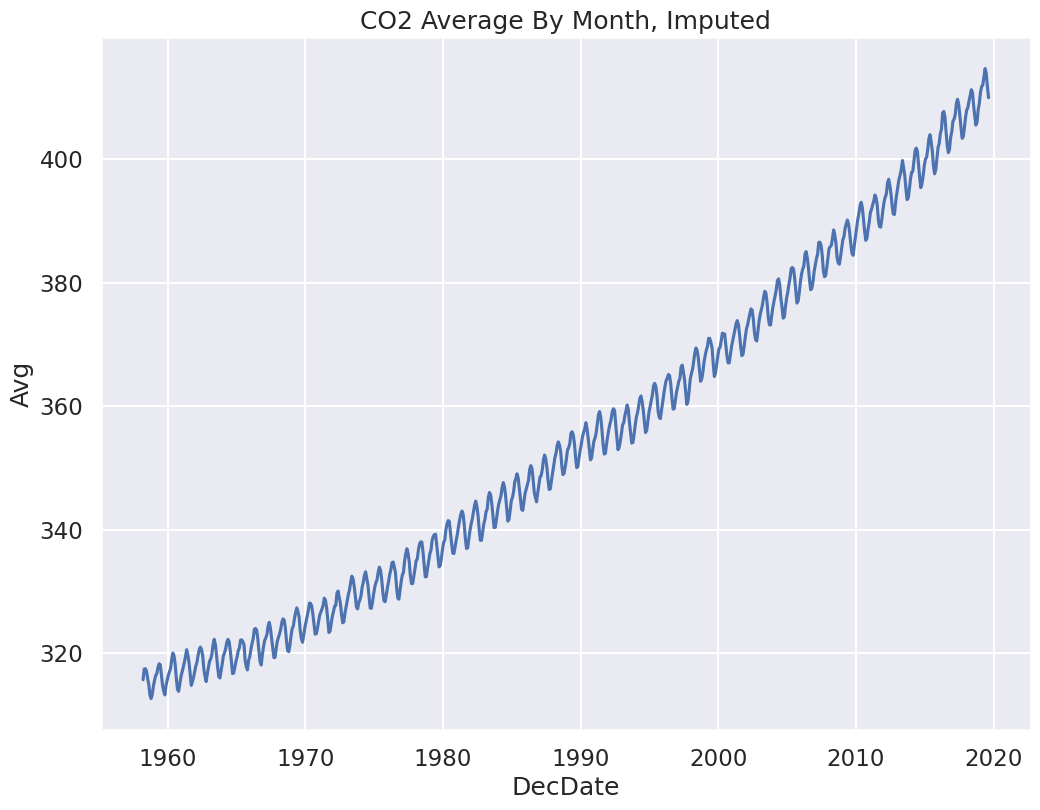

In [46]:
sns.lineplot(x='DecDate', y='Avg', data=co2_impute)
plt.title("CO2 Average By Month, Imputed");

Looks pretty close to what we see on the NOAA [website](https://gml.noaa.gov/ccgg/trends/)!

### Presenting the data: A Discussion on Data Granularity

From the description:
* monthly measurements are averages of average day measurements.
* The NOAA GML website has datasets for daily/hourly measurements too.

The data you present depends on your research question.

**How do CO2 levels vary by season?**
* You might want to keep average monthly data.

**Are CO2 levels rising over the past 50+ years, consistent with global warming predictions?**
* You might be happier with a **coarser granularity** of average year data!

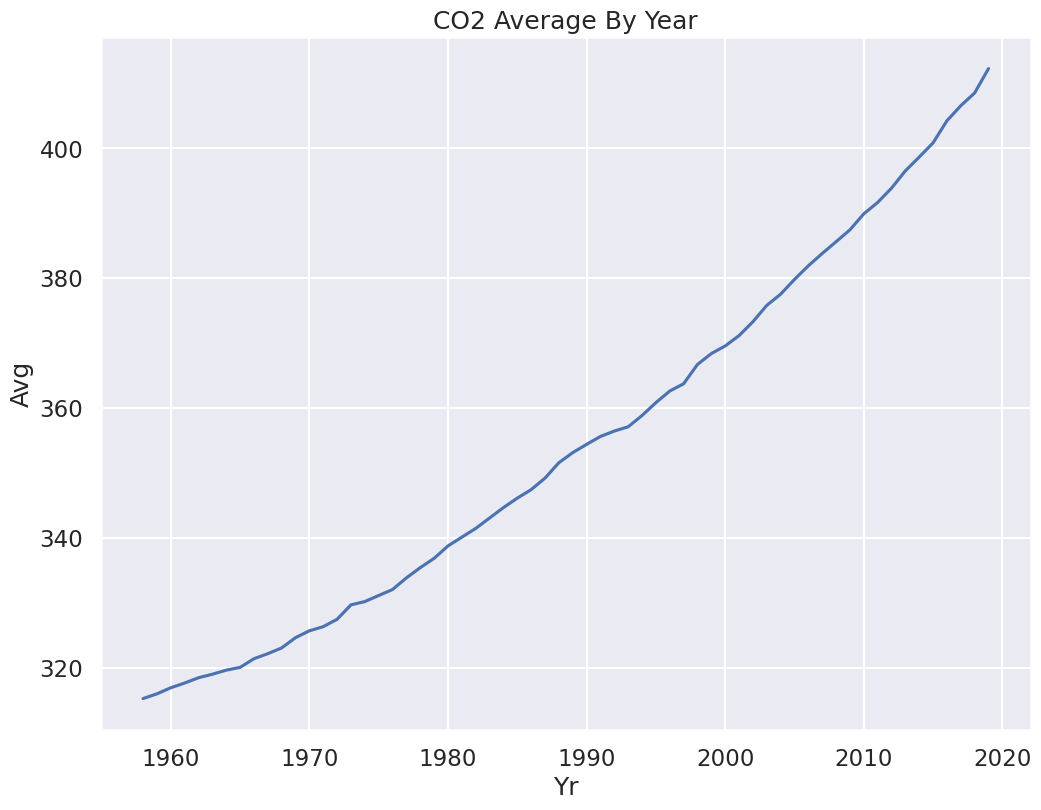

In [47]:
co2_year = co2_impute.groupby('Yr').mean()
sns.lineplot(x='Yr', y='Avg', data=co2_year)
plt.title("CO2 Average By Year");

Indeed, we see a rise by nearly 100 ppm of CO2 since Mauna Loa began recording in 1958.